# Notebook 04: Predictive Model

## Table of Contents
1. [Setup and Feature Selection](#setup)
    * Load Engineered Features
2. [Stratified Train-Test Split](#split)
    * User Requirement: Equal split of Win/Loss in both Train and Test.
    * Method: Stratified Shuffle Split (Randomized).
3. [Random Forest Classifier](#rf-model)
    * Model Training 
4. [Evaluation Metrics](#evaluation)
    * Accuracy, Precision, Recall, ROC-AUC.
    * Confusion Matrix .
5. [Feature Importance Analysis](#feature-importance)
    * Identifying the Drivers of Profitability..
6. [Clustering](#clustering)
    * K-Means Clustering .
    * Visualizing Behavior across Regimes .
7. [Export](#export)

### 1. Setup and Feature Selection
<a id="setup"></a>

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
import os


PROCESSED_DATA_PATH = '../data/processed'
OUTPUT_FIGURES_PATH = '../outputs/figures'
OUTPUT_MODELS_PATH = '../outputs/models'
os.makedirs(OUTPUT_FIGURES_PATH, exist_ok=True)
os.makedirs(OUTPUT_MODELS_PATH, exist_ok=True)

df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, '02_engineered_features.csv'))
df['date'] = pd.to_datetime(df['date'])

target_col = 'target_profitable_next_day'
df_model = df.dropna(subset=[target_col]).copy()

feature_cols = [
    'sentiment_score', 'avg_leverage', 'total_volume', 'trade_frequency',
    'aggression_score', 'long_short_ratio', 'risk_sentiment_interaction',
    'prev_net_pnl', 'prev_win_rate', 'prev_total_volume'
]

X = df_model[feature_cols].fillna(0)
y = df_model[target_col]

print(f"Modeling Dataset Shape: {X.shape}")
print(f"Global Win Rate: {y.mean():.2%}")

Modeling Dataset Shape: (102, 10)
Global Win Rate: 57.84%


### 2. Stratified Train-Test Split
<a id="split"></a>

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,      
    shuffle=True,    
    random_state=42
)

print(f"Train Set Shape: {X_train.shape} | Win Rate: {y_train.mean():.2%}")
print(f"Test Set Shape:  {X_test.shape} | Win Rate: {y_test.mean():.2%}")

Train Set Shape: (81, 10) | Win Rate: 58.02%
Test Set Shape:  (21, 10) | Win Rate: 57.14%


### 3. Random Forest Classifier 
<a id="rf-model"></a>

In [31]:
rf_model = RandomForestClassifier(
    n_estimators=200,      
    max_depth=7,            
    min_samples_split=5,
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Model Training Complete.")

Model Training Complete.


### 4. Evaluation & Threshold Tuning
<a id="evaluation"></a>


--- Model Performance (Stratified) ---
Accuracy:    0.7619
Precision:   0.7692
Recall:      0.8333
ROC-AUC:     0.8148


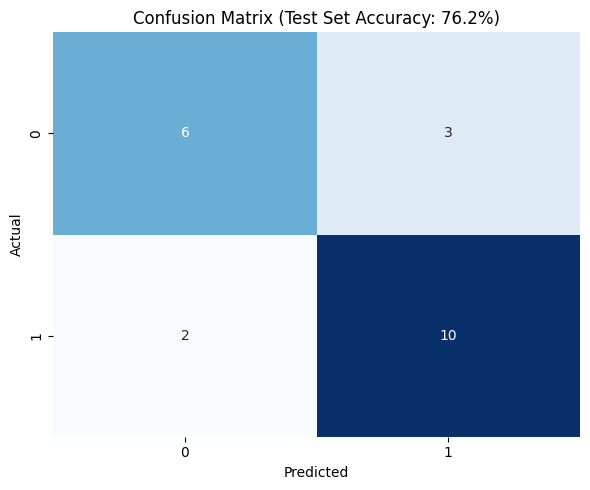

In [32]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_prob)

print("\n--- Model Performance (Stratified) ---")
print(f"Accuracy:    {acc:.4f}")
print(f"Precision:   {prec:.4f}")
print(f"Recall:      {rec:.4f}")
print(f"ROC-AUC:     {roc:.4f}")

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Test Set Accuracy: {acc:.1%})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, '13_confusion_matrix_final.png'))
plt.show()

### 5. Feature Importance 
<a id="feature-importance"></a>

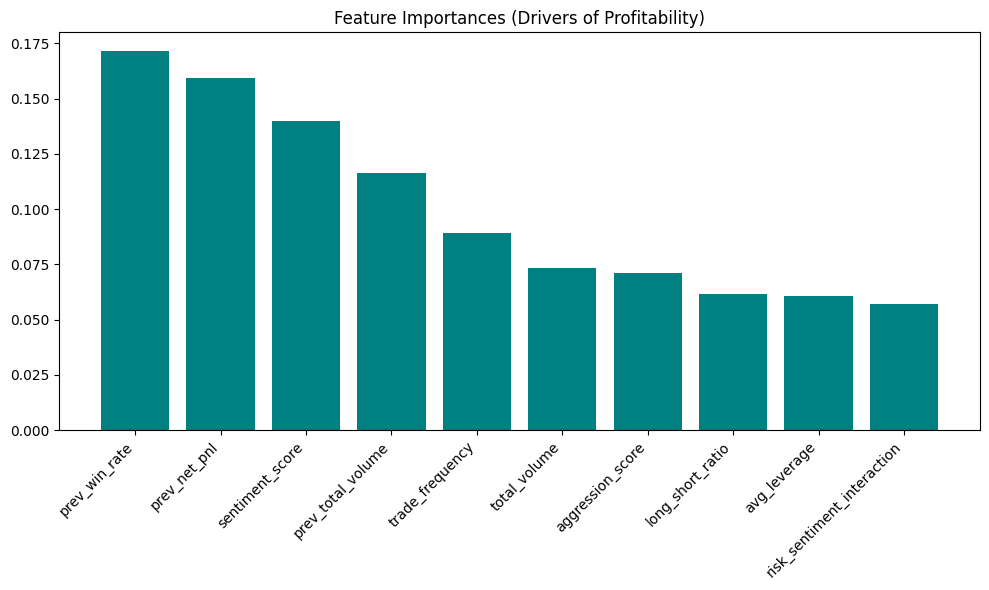


Top 3 Predictive Features:
1. prev_win_rate (0.1715)
2. prev_net_pnl (0.1592)
3. sentiment_score (0.1399)


In [33]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Drivers of Profitability)")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='teal')
plt.xticks(range(X.shape[1]), [feature_cols[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, '14_feature_importance_final.png'))
plt.show()

print("\nTop 3 Predictive Features:")
for i in range(3):
    print(f"{i+1}. {feature_cols[indices[i]]} ({importances[indices[i]]:.4f})")



### 6. Clustering
<a id="clustering"></a>

--- Cluster Centroids ---
                total_volume  trade_frequency  avg_leverage   prev_net_pnl  \
kmeans_cluster                                                               
0               4.912002e+06      1249.076923    377.100808  -11060.922592   
1               6.911625e+06      1896.953488   1054.503167  167251.027772   
2               1.277001e+08     12938.400000    752.172834  362572.216937   
3               3.145012e+04         5.500000  32775.338192       0.000000   

                prev_win_rate  
kmeans_cluster                 
0                    0.152075  
1                    0.497406  
2                    0.328291  
3                    0.000000  

--- Identified Archetypes ---
cluster_label
Churners (Retail)      52
Sharps (Profitable)    43
HFT Whales              5
Degens (High Lev)       2
Name: count, dtype: int64


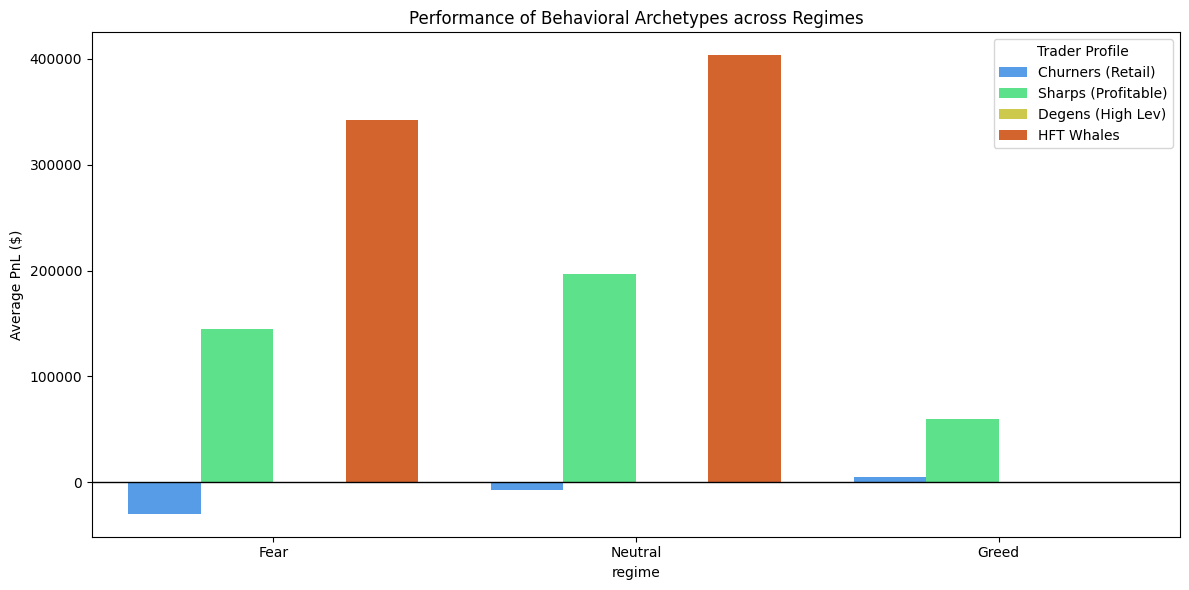

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os

PROCESSED_DATA_PATH = '../data/processed'
OUTPUT_FIGURES_PATH = '../outputs/figures'

features = ['total_volume', 'trade_frequency', 'avg_leverage', 'prev_net_pnl', 'prev_win_rate']
X_cluster = df[features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df['kmeans_cluster'] = clusters

summary = df.groupby('kmeans_cluster')[features].mean()
print("--- Cluster Centroids ---")
print(summary)

id_whales = summary['total_volume'].idxmax()
id_degens = summary['avg_leverage'].idxmax()
remaining = summary.drop([id_whales, id_degens])
id_sharps = remaining['prev_net_pnl'].idxmax()
all_ids = set(summary.index)
assigned_ids = {id_whales, id_degens, id_sharps}
id_churners = list(all_ids - assigned_ids)[0]

label_map = {
    id_whales: "HFT Whales",
    id_degens: "Degens (High Lev)",
    id_sharps: "Sharps (Profitable)",
    id_churners: "Churners (Retail)"
}
df['cluster_label'] = df['kmeans_cluster'].map(label_map)

print("\n--- Identified Archetypes ---")
print(df['cluster_label'].value_counts())

if 'sentiment_score' in df.columns:
    df['regime'] = pd.cut(df['sentiment_score'], bins=[0, 45, 55, 100], labels=['Fear', 'Neutral', 'Greed'])
    plt.figure(figsize=(12, 6))
    sns.barplot(x='regime', y='prev_net_pnl', hue='cluster_label', data=df, palette='turbo', errorbar=None)
    plt.title('Performance of Behavioral Archetypes across Regimes')
    plt.ylabel('Average PnL ($)')
    plt.axhline(0, color='black', linewidth=1)
    plt.legend(title='Trader Profile')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_FIGURES_PATH, '15_cluster_performance.png'))
    plt.show()

### 7. Export
<a id="export"></a>

In [35]:
import joblib
import os

OUTPUT_MODELS_PATH = '../outputs/models'
os.makedirs(OUTPUT_MODELS_PATH, exist_ok=True)

rf_filename = os.path.join(OUTPUT_MODELS_PATH, 'rf_prediction_model.joblib')
kmeans_filename = os.path.join(OUTPUT_MODELS_PATH, 'kmeans_model.joblib')
scaler_filename = os.path.join(OUTPUT_MODELS_PATH, 'kmeans_scaler.joblib')

joblib.dump(rf_model, rf_filename)
joblib.dump(kmeans, kmeans_filename)
joblib.dump(scaler, scaler_filename)

print("\n--- Model Registry Export ---")
print(f"1. Random Forest saved to: {rf_filename}")
print(f"2. K-Means Model saved to: {kmeans_filename}")
print(f"3. Scaler saved to:        {scaler_filename}")



--- Model Registry Export ---
1. Random Forest saved to: ../outputs/models\rf_prediction_model.joblib
2. K-Means Model saved to: ../outputs/models\kmeans_model.joblib
3. Scaler saved to:        ../outputs/models\kmeans_scaler.joblib
